In [1]:
import sys
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy.ndimage import zoom
from scipy import spatial
from copy import copy
import shapefile
from shapely.geometry import Point
from shapely.geometry import shape
import subprocess
from IPython.display import display, clear_output #needed for animated plots
from inpaint_nans import inpaint_nans

In [2]:
nan_value = -9999
resample = .5
res = 50 / resample

S_ref = np.flip(np.loadtxt("02_surface_Synthetic2_0000_UTM00.asc", skiprows=6), axis=0)
S_ref[S_ref == nan_value] = 0
S_ref = zoom(S_ref, resample)
M_ref = np.flip(np.loadtxt("04_mb_Synthetic2_0000-0001_UTM00.asc", skiprows=6), axis=0)
M_ref[M_ref == nan_value] = 0
M_ref = zoom(M_ref, resample)
dhdt_ref = np.flip(np.loadtxt("05_dhdt_Synthetic2_0000-0001_UTM00.asc", skiprows=6), axis=0)
dhdt_ref[dhdt_ref == nan_value] = 0
dhdt_ref = zoom(dhdt_ref, resample)
u_ref = np.flip(np.loadtxt("06_speed_Synthetic2_0000_UTM00.asc", skiprows=6), axis=0)
u_ref[u_ref == nan_value] = 0
u_ref = zoom(u_ref, resample)
az_ref = np.flip(np.loadtxt("07_azimuth_Synthetic2_0000_UTM00.asc", skiprows=6), axis=0)
az_ref[az_ref == nan_value] = 0
az_ref = zoom(az_ref, resample)
u_vel_ref = np.cos(1-np.deg2rad(az_ref))*u_ref
u_vel_ref[az_ref<0] = 0
u_vel_ref[az_ref>360] = 0
v_vel_ref = np.cos(np.deg2rad(az_ref))*u_ref
v_vel_ref[az_ref<0] = 0

ny, nx = np.shape(S_ref)

outline = shapefile.Reader("./shapefiles/01_margin_Synthetic2_0000_UTM00.shp").shapes()[0]
mask = np.zeros_like(S_ref)
for j in range(np.shape(mask)[0]):
    for k in range(np.shape(mask)[1]):
        if Point([(((k-6)*res)+outline.bbox[0]),(((j-0)*res)+outline.bbox[1])]).within(shape(outline)):
            mask[j,k] = 1

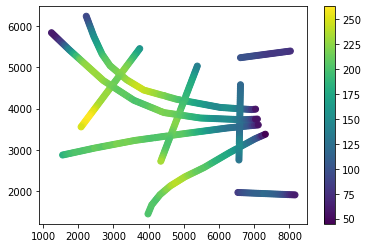

In [72]:
pNR, dist, x_coord, y_coord, z_surf, z_bed, thick = np.loadtxt("03_RES_Synthetic2_UTM00.txt", skiprows=17, unpack=True)
Pro = np.unique(pNR)
nPro = len(Pro)
indPro = []
count = 0
for i in Pro:
    indPro.append(len(pNR[pNR==i])+count)
    count+=i

fig, ax = plt.subplots()
field = ax.scatter(x_coord, y_coord, c=thick)
fig.colorbar(field)

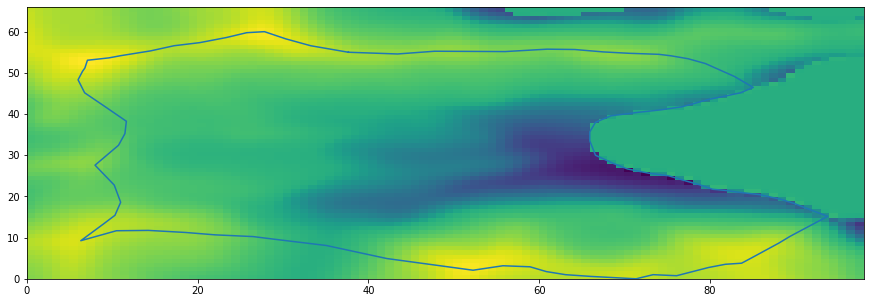

In [4]:
x = [(i[0]-outline.bbox[0])/res+6 for i in (outline).points[:]]
y = [(i[1]-outline.bbox[1])/res+0 for i in (outline).points[:]]
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x,y)
ax.pcolor(M_ref)

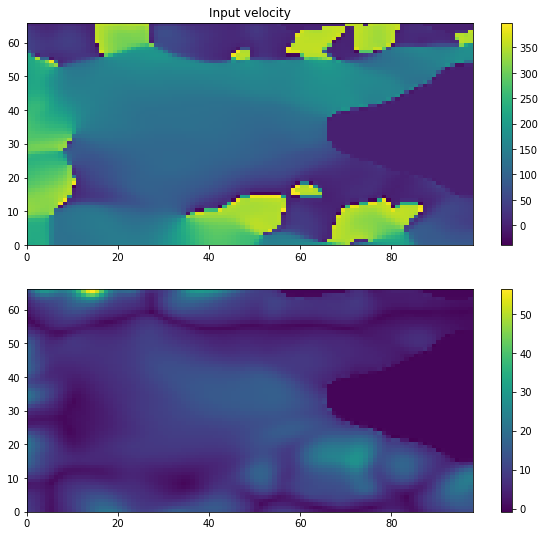

In [5]:
def plots(nrow=1, ncol=2, size=(10,4)):
    fig, axes = plt.subplots(nrow, ncol, figsize=size)
    for ax in axes:
        ax.set_box_aspect(1)
    return fig, axes

fig, axes = plt.subplots(2,1, figsize = (10,9))
field = axes[0].pcolor(az_ref, axes=axes[0])
fig.colorbar(field, ax=axes[0])
axes[0].set_title('Input velocity')
fi = axes[1].pcolor(u_ref, axes=axes[1])
fig.colorbar(fi, ax=axes[1])

In [6]:
ice_temp = 268
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))
print(A)

1.2597213016951452e-24


In [7]:
filename = "synthetic_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {"ocean.always_grounded": "yes",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 910.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.81,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [8]:
WRIT_FILE = 'synthetic_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 910.0             # [kg m-3]

Lx = nx * res  # in m
Ly =  ny * res # in m

# grid size: extent in km's, origin (0,0) in the center of the domain

x = np.linspace(-Lx/2, Lx/2, nx)
y = np.linspace(-Ly/2, Ly/2, ny)

B_rec = S_ref
B_init = copy(B_rec)
ice_surface_temp = np.ones((ny, nx))*273
land_ice_area_fraction_retreat = np.ones_like(S_ref)
M_ref = np.nan_to_num(M_ref)
M_ref *= mask

h_rec = S_ref - B_rec

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['km',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['km',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'ice thickness',
                 'land_ice_thickness',
                 1.0,
                 h_rec],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 B_rec],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             273,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0,
                                  M_ref * ice_density],
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  synthetic_initialSetup.nc  created



In [9]:
def create_script(forward_or_iteration, nx, ny):
    print("""#!/bin/bash
    ###### run script for experiment synthetic1 ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx {} -My {} -Mz 10 -Mbz 1 -Lz 1000 -Lbz 1"'.format(nx, ny))
    print('PHYS="-stress_balance ssa+sia -sia_flow_law isothermal_glen -ssa_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    print('OCEAN="-dry"')
    print('CONF="-config_override synthetic_conf.nc"')# -front_retreat_file synthetic_max_extent.nc -geometry.front_retreat.prescribed.period 100"')
    #print('DIF="-limit_sia_diffusivity -stress_balance.sia.max_diffusivity $OPT5 -time_stepping.adaptive_ratio 0.12"')
    #print('ENHANCE="-sia_e 1e5 -sia_n 2 -ssa_e 10"')
    #print('REGRID="-regrid_file $CLIMATEFILE -bootstrap -allow_extrapolation"')# -regrid_vars thk,topg"')
    #print('OUTPUT="-save_size big -output.sizes.big uvel,vvel"')
   
    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 10e7"')
    #print('SLIDING="-stress_balance.weertman_sliding.k 0.2 -stress_balance.weertman_sliding.A 3e-15 -enthalpy_converter.relaxed_is_temperate_tolerance 1000"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# initialize synthetic glacier"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,uvel,vvel,mask,thk,usurf,velbase_mag,enthalpybase,bwat"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=1')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times $OUTPUT"')
    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} -bed_smoother_range 200 $CONF $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $DIF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [10]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('synthetic_initialize.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward', nx, ny)
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()
    
!chmod +x synthetic_initialize.sh
!./synthetic_initialize.sh 4 synthetic_initialSetup.nc 1 synthetic_output.nc > synthetic_output_log.txt

In [11]:
def get_nc_data(file, var, time):
    ds = NC(file)
    avail_vars = [nc_var for nc_var in ds.variables]
    if var not in avail_vars:
        raise ValueError('variable not found; must be in {}'.format(avail_vars))
    else:
        var_data = ds[var][time][:]
    return var_data

In [12]:
## shifted dhdt-field
from scipy.interpolate import griddata

def shift(data, u, v):
    x_shift, y_shift = np.meshgrid(range(nx), range(ny))
    uv_mag = np.ones_like(u)
    uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
    x_shift = x_shift+(u/uv_mag)*.3
    y_shift = y_shift+(v/uv_mag)*.3

    points = np.zeros((np.shape(u)[0]*np.shape(u)[1],2))
    points[:,0] = x_shift.flatten()
    points[:,1]=y_shift.flatten()
    xi, yi = np.meshgrid(range(nx), range(ny))

    newgrid = griddata(points, data.flatten(), (xi.flatten(), yi.flatten()), method='linear').reshape(np.shape(u))
    return newgrid

0.9749304320633543
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
0.7671828298868586
98.50235


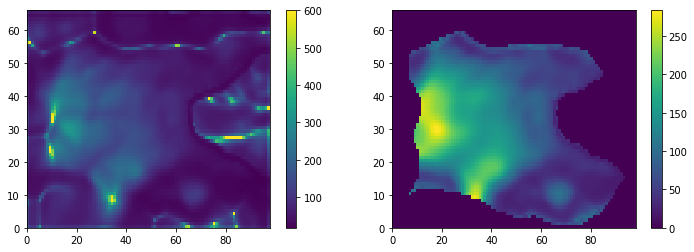

In [13]:
import richdem as rd
import math

dH = (np.nanmax(S_ref[mask==1])-np.nanmin(S_ref[mask==1]))/1000 #in km

tau = 0.005+1.598*dH-0.435*dH**2  #Haeberli and Hoelzle
print(tau)

slope = rd.TerrainAttribute(rd.rdarray(S_ref, no_data=-9999), attrib='slope_riserun')
tan_slope = np.arctan(slope/res)
sin_slope = np.sin(tan_slope)
H=(tau)*1e5/(sin_slope*9.81*ice_density)
H[np.isnan(H)]=0
fig, ax = plt.subplots(1,2, figsize=(12,4))
field = ax[0].pcolor(H, vmax=600)
fig.colorbar(field,ax=ax[0])
print(dH)
print(np.mean(H))

def smooth_stress_coupling(H, field, mask, scl, max_scl):
    field_new = np.zeros_like(field)
    for i in range(nx):
        for j in range(ny):
            if mask[j,i]==0:
                field_new[j,i] = field[j,i]
            else:
                x, y = np.ogrid[:np.shape(H)[0], :np.shape(H)[1]]
                coupling_length = scl*(H[j,i]/res)**2
                circle = (y - i) ** 2 + (x - j) ** 2 <= (min(coupling_length,max_scl)/2)**2
                field_new[j,i]= np.mean(field[np.logical_and(circle, mask==1)])
    return field_new
            
sin_slope_smooth = smooth_stress_coupling(H, sin_slope, mask, 4, 8)
H_smooth=(tau)*1e5/(sin_slope_smooth*9.81*ice_density)
field = ax[1].pcolor(H_smooth*mask)
fig.colorbar(field, ax=ax[1])

In [63]:
### bed recovery ###
from scipy.signal import spline_filter

S_ref = np.flip(np.loadtxt("02_surface_Synthetic2_0000_UTM00.asc", skiprows=6), axis=0)
S_ref[S_ref == nan_value] = 0
S_ref = zoom(S_ref, resample)
S_rec = copy(S_ref)

B_rec = np.maximum(S_ref-300, S_ref-H_smooth*mask)
#B_rec = S_ref
B_init = copy(B_rec)
dh_ref = copy(dhdt_ref)

B_rec_all = []
dh_all = []
misfit_all = []
B_misfit_vs_iter=[]
dh_misfit_vs_iter=[]

pmax = 500
dt = .1
beta = .9
bw = 2

!cp synthetic_output.nc synthetic_iteration_out.nc
    
original_stdout = sys.stdout
with open('synthetic_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x synthetic_iteration_script.sh

In [64]:
for p in tqdm.trange(0, pmax):
    
    h_old = S_rec - B_rec
    
    !cp synthetic_iteration_out.nc synthetic_iteration_in.nc
    nc_updated = NC('synthetic_iteration_in.nc', 'r+')
    nc_updated['topg'][0,:,:]=B_rec
    nc_updated['thk'][0,:,:]=h_old
    #dif = nc_updated['diffusivity'][0,:,:]
    nc_updated.close()
    
    #if p>0:
    #    set_max_dif.append(np.nanmean(dif[dif>0]))
    
    cmd = ["./synthetic_iteration_script.sh", '2', 'synthetic_iteration_in.nc', str(dt), 'synthetic_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('synthetic_iteration_log.txt', 'a'))
    
    #h_rec = get_nc_data('s_synthetic_iteration_out.nc', 'thk', 1)
    h_rec2 = get_nc_data('synthetic_iteration_out.nc', 'thk', 0)
    
    dh_rec = (h_rec2 - h_old)/dt
    
    mask_iter = get_nc_data('synthetic_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2
    criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)
    
    misfit = (dh_rec - dh_ref)
    u = get_nc_data('synthetic_iteration_out.nc', 'uvelsurf', 0)
    u[criterion]=0
    v = get_nc_data('synthetic_iteration_out.nc', 'vvelsurf', 0)
    v[criterion]=0
    
    misfit = shift(misfit, u, v)
    
    #misfit = ndimage.convolve(misfit, np.ones((2,2)))/4
    #misfit = spline_filter(misfit, lmbda=1)

    B_rec -= beta * misfit
    S_rec[np.logical_and(mask==1, h_rec2>20)] += (beta*0.05) * misfit[np.logical_and(mask==1, h_rec2>20)] 
    
    B_rec = ndimage.gaussian_filter(B_rec, .3)

    #S_rec[criterion] = S_ref[criterion]
    
    #B_rec_smooth = copy(B_rec)
    #B_rec_smooth[mask==0] = np.nan
    
    #if p%100 == 0:
    #    B_rec = spline_filter(B_rec, lmbda=1)
    
    #B_rec[mask==1] = B_rec_smooth[mask==1]
    #B_rec[B_rec>S_ref]=S_ref[B_rec>S_ref]
    #B_rec[mask == 0]= S_ref[mask == 0]
    #B_rec[np.logical_and(mask==1, B_rec==S_ref)] = np.nan
    #if np.any(np.isnan(B_rec)):
    #    B_rec = inpaint_nans(B_rec)
    
    ### buffer ###    
    h_inpaint = S_rec-B_rec
    h_inpaint[criterion] = np.nan #...and take those values in the transition between ice and no ice;
    h_inpaint = inpaint_nans(h_inpaint)
    B_rec = S_rec - h_inpaint
    ### buffer end ###
        
    B_rec[B_rec>S_rec]=S_rec[B_rec>S_rec]
    B_rec[B_rec>S_ref]=S_ref[B_rec>S_ref]
    B_rec[mask == 0]= S_ref[mask == 0]
    S_rec[mask == 0]= S_ref[mask == 0]
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    misfit_all.append(misfit)
    
    B_misfit_vs_iter.append(np.mean(abs(B_rec-B_init)))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec-dh_ref)))

  0%|          | 0/500 [00:00<?, ?it/s]/home/thomas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
100%|██████████| 500/500 [07:28<00:00,  1.11it/s]


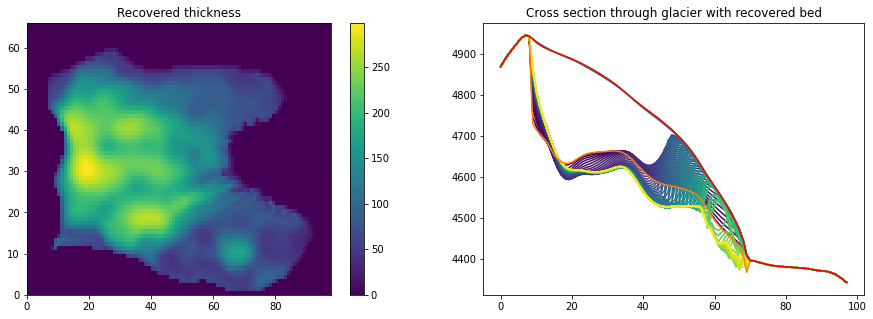

In [65]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(S_rec- B_rec)#spline_filter(S_rec-B_rec_all[-1], lmbda=1))
fig.colorbar(field, ax=axes[0])
axes[0].set_title('Recovered thickness')
for i in range(0,len(B_rec_all),5):
    lines = axes[1].plot(range(nx), B_rec_all[i][27,:], color = colors[i])#ndimage.convolve(B_rec_all[i], np.ones((4,4))/16)[15,:], color=colors[i])
lines2 = axes[1].plot(range(nx), S_ref[27,:])
lines2 = axes[1].plot(range(nx), B_init[27,:])
usurf = get_nc_data('synthetic_iteration_out.nc', 'usurf',0)
line3 = axes[1].plot(range(nx), usurf[27,:])
axes[1].set_title('Cross section through glacier with recovered bed')
lines4 = axes[1].plot(range(nx), S_rec[27,:], color='r')

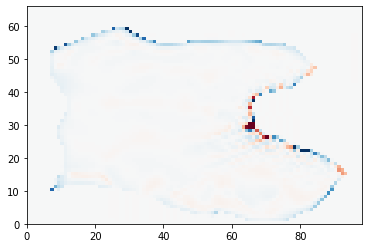

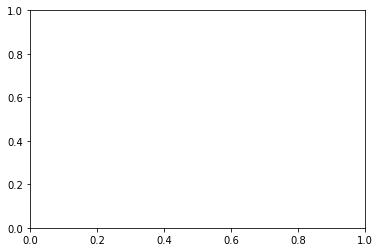

In [69]:
from celluloid import Camera
fig, axes = plt.subplots()
#camera = Camera(fig)
for i in range(0,len(B_rec_all),10):
    field = axes.pcolor(misfit_all[i], cmap='RdBu', vmin=-2, vmax=2)
    #field = axes.pcolor(S_ref-B_rec_all[i], vmax=300)
    #camera.snap()
    clear_output(wait=True)
    display(fig)
    axes.cla()
#animation = camera.animate()
#animation.save('dhdt_misfit_nonhomegrown_SIA.mp4')

In [67]:
import numpy as np, scipy.stats as st
max_cor_ind = int(np.where(cors==np.max(cors))[0])
dev = (thk_rec_all[-1][y_new,x_new]-thick)/125.3 #125.3 is value from ITMIX2
mean_dev = np.nanmean((dev))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
print('mean deviation: {}'.format(mean_dev))
print('median deviation: {}'.format(med_dev))
print('Interquartile range of deviation: {}'.format(IQR_dev))
print('95% confidence intervall: {}'.format(conf_dev))

mean deviation: -0.050438310543769904
median deviation: -0.030054376551111282
Interquartile range of deviation: 0.12729869805964522
95% confidence intervall: [ 0.01306259 -0.01306259]


(0.0, 262.9)

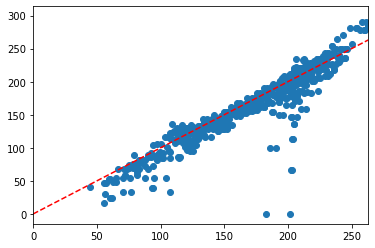

In [66]:
x_new = ((x_coord-outline.bbox[0])/res+12*resample).astype('int')
y_new = ((y_coord-outline.bbox[1])/res+0).astype('int')
cors = []
thk_rec_all = []
for i in range(0,len(B_rec_all),1):
    thk_rec = S_rec- B_rec_all[i]#ndimage.convolve(S_ref-B_rec_all[-1], np.ones((4,4))/16)
    thk_rec_all.append(thk_rec)
    cors.append(np.corrcoef(thick, thk_rec[y_new,x_new])[0][1])

fig, ax = plt.subplots()
field = ax.scatter(thick, thk_rec_all[-1][y_new, x_new])
ax.plot(range(300), range(300), 'r', linestyle='--')
ax.set_xlim([0,np.max(thick)])
#ax.set_ylim([0,np.max(thick)])

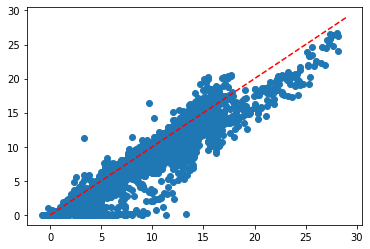

In [77]:
fig, ax = plt.subplots()
field = ax.scatter(u_ref, get_nc_data('synthetic_iteration_out.nc', 'velsurf_mag', 0))
ax.plot(range(30), range(30), 'r', linestyle='--')

Text(0.5, 1.0, 'dhdt misfit')

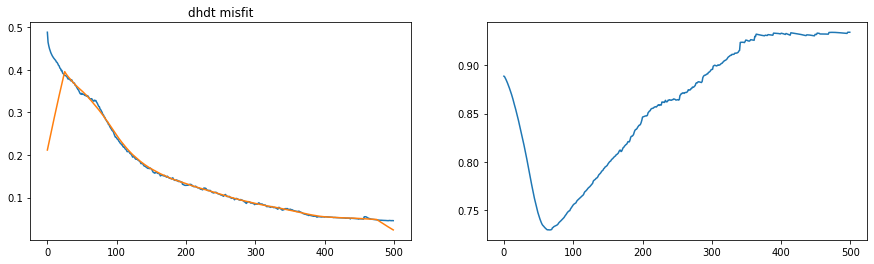

In [68]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
line = ax[0].plot(dh_misfit_vs_iter)
line1 = ax[0].plot(np.convolve(dh_misfit_vs_iter, np.ones(50)/50, mode='same'))
line2 = ax[1].plot(cors)
ax[0].set_title('dhdt misfit')

In [183]:
### grow glacier on smoothed reconstructed bed
B_recs=copy(B_rec_all[-1])
B_recs[S_ref-B_rec_all[-1]>350] = np.nan
B_recs = inpaint_nans(B_recs)
B_recs= ndimage.convolve(B_recs, np.ones((5,5)))/5**2
M_ref2 = np.flip(np.loadtxt("04_mb_Synthetic2_0000-0001_UTM00.asc", skiprows=6), axis=0)
M_ref2[M_ref2 == nan_value] = -1
M_ref2 = zoom(M_ref2, resample)
M_ref2[mask == 0] = -1

nc_restart = NC('synthetic_initialSetup.nc', 'r+')
nc_restart['thk'][:,:] = np.zeros_like(S_ref)
nc_restart['topg'][:,:] = B_recs
nc_restart['climatic_mass_balance'][:,:] = M_ref2 * ice_density
nc_restart.close()

original_stdout = sys.stdout
with open('synthetic_build_script.sh', 'w') as f:
    sys.stdout = f
    create_script('forward', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x synthetic_build_script.sh
    
cmd = ["./synthetic_build_script.sh", '7', 'synthetic_initialSetup.nc', str(1200), 'synthetic_build_out.nc']
subprocess.call(cmd, stdout=open('synthetic_build_log.txt', 'w'))

0

In [760]:
### grow glacier on smoothed reconstructed bed
B_recs2=get_nc_data('synthetic_build_out.nc', 'topg', 0)
M_ref2 = np.flip(np.loadtxt("04_mb_Synthetic2_0000-0001_UTM00.asc", skiprows=6), axis=0)
M_ref2[M_ref2 == nan_value] = -1
M_ref2 = zoom(M_ref2, resample)
M_ref2[mask == 0] = -1

nc_restart = NC('synthetic_initialSetup.nc', 'r+')
nc_restart['thk'][:,:] = np.zeros_like(S_ref)
nc_restart['topg'][:,:] = B_recs2
nc_restart['climatic_mass_balance'][:,:] = M_ref2 * ice_density
nc_restart.close()

original_stdout = sys.stdout
with open('synthetic_build_script2.sh', 'w') as f:
    sys.stdout = f
    create_script('forward', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x synthetic_build_script2.sh
    
cmd = ["./synthetic_build_script2.sh", '7', 'synthetic_initialSetup.nc', str(1200), 'synthetic_build_out2.nc']
subprocess.call(cmd, stdout=open('synthetic_build_log.txt', 'w'))

0

In [12]:
def scale(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

In [117]:
original_stdout = sys.stdout
with open('synthetic_iteration_script2.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    

In [116]:
!cp synthetic_build_out.nc synthetic_test_in.nc
nc_test = NC('synthetic_test_in.nc', 'r+')
topg_def = get_nc_data('synthetic_build_out.nc', 'topg', 0)
thk_def = get_nc_data('synthetic_build_out.nc', 'thk', 0)
topg_adjust = copy(topg_def)
thk_adjust = copy(thk_def)
random_noise = np.random.rand(np.shape(topg_def)[0], np.shape(topg_def)[1])*10
topg_adjust[mask2==1] += random_noise[mask2==1]
thk_adjust[mask2==1] = np.maximum(0,thk_adjust[mask2==1]-random_noise[mask2==1])
#topg_adjust[12:17, 70:80]+=10
#thk_adjust[12:17, 70:80]-=10
nc_test['topg'][0,:,:]= topg_adjust
nc_test['thk'][0,:,:]= thk_adjust
nc_test.close()

In [118]:
dts = [.1]#, .5, 1, 2, 3, 5, 7, 10, 15, 20]
dt_fields = []
h_outs = []
h_outs_dot1 =[]
for i,t in enumerate(dts):
    cmd = ["./synthetic_iteration_script2.sh", '3', 'synthetic_test_in.nc', str(t+.1), 'synthetic_iteration_out2.nc', str(t)]
    subprocess.call(cmd, stdout=open('synthetic_iteration_log2.txt', 'a'))
    
    h_outs.append(get_nc_data('s_synthetic_iteration_out2.nc', 'thk', -1))
    h_outs_dot1.append(get_nc_data('synthetic_iteration_out2.nc', 'thk', 0))
    dt_fields.append(h_outs_dot1[i]-h_outs[i])

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


Text(0.5, 1.0, 'shifted dhdt')

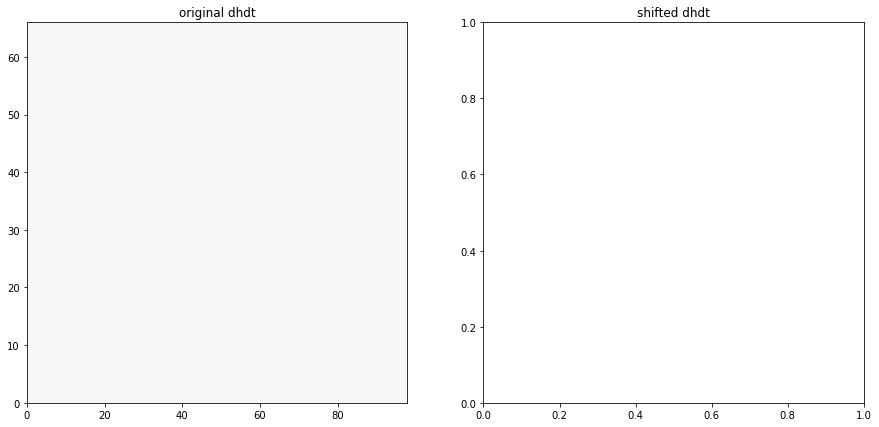

In [121]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(dts))]
fig, ax = plt.subplots(1,2,figsize=(15,7))
#for i in range(0, len(dts)):
    #ax[0].plot(range(ny), dt_fields[i][:,60], color=colors[i])
    
ax[0].pcolor(dt_fields[0], vmin=-.5, vmax=.5, cmap='RdBu')
#ax[1].contour(h_outs_dot1[0], levels=np.array([100,150]))
slope = rd.TerrainAttribute(rd.rdarray(S_ref2, no_data=-9999), attrib='slope_riserun')
slope[mask==0] = np.nan
#ax[1].pcolor(newgrid, vmin=-.5, vmax=.5, cmap='RdBu')
#ax[0].contour(slope, levels=np.array([16]))
ax[0].set_title('original dhdt')
ax[1].set_title('shifted dhdt')

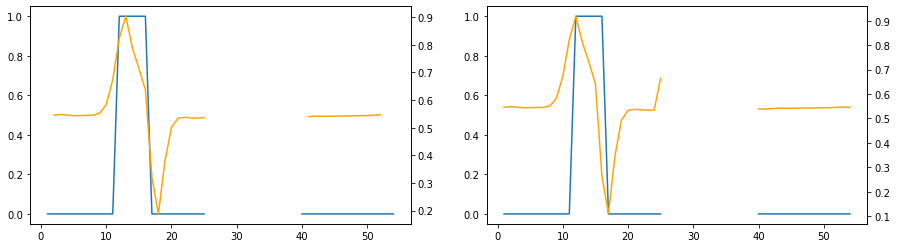

In [947]:
data = topg_adjust-topg_def
data[mask2==0] = np.nan
data = scale(data)
data2 = slope
data2 = scale(data2)
dt_field = dt_fields[0]
dt_field[mask2==0] = np.nan
dt_field = scale(dt_field)

fig, ax = plt.subplots(1,2, figsize=(15,4))
field2 = ax[0].plot(range(ny), data[:,70])
#field2 = ax[0].plot(range(nx), data2[15,:], color='r')
ax1 = ax[0].twinx()
field = ax1.plot(range(ny), newgrid[:,70], color='orange')


line = ax[1].plot(range(ny), data[:,70])
ax2 = ax[1].twinx()
line1 = ax2.plot(range(ny), dt_field[:,70], color='orange')

In [111]:
## shifted dhdt-field
from scipy.interpolate import griddata
u = get_nc_data('synthetic_iteration_out2.nc', 'uvelsurf', 0)
v = get_nc_data('synthetic_iteration_out2.nc', 'vvelsurf', 0)

def shift(data, u, v):
    x_shift, y_shift = np.meshgrid(range(nx), range(ny))
    uv_mag = np.ones_like(u)
    uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)

    x_shift = x_shift+(u/uv_mag)*.5
    y_shift = y_shift+(v/uv_mag)*.5

    points = np.zeros((np.shape(u)[0]*np.shape(u)[1],2))
    points[:,0] = x_shift.flatten()
    points[:,1]=y_shift.flatten()
    xi, yi = np.meshgrid(range(nx), range(ny))

    newgrid = griddata(points, data.flatten(), (xi.flatten(), yi.flatten())).reshape(np.shape(u))
    return newgrid

#newgrid = shift(dt_field, u,v)

Text(0.5, 1.0, 'random noise - shifted dhdt')

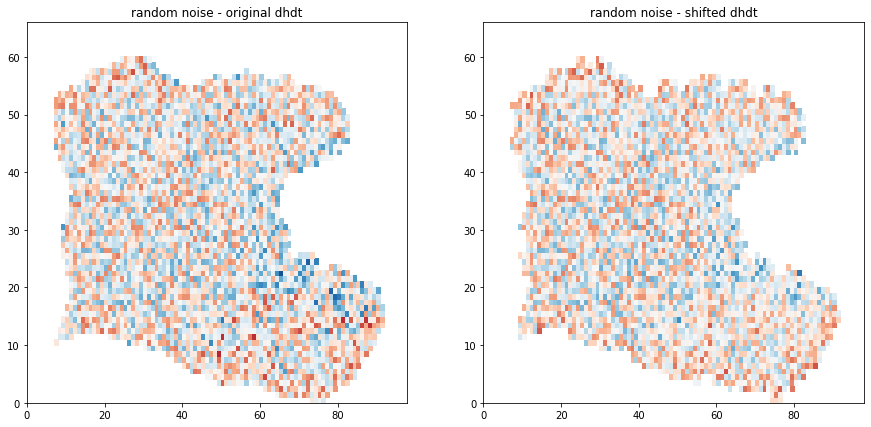

In [924]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].pcolor(data-dt_field, vmin=-1, vmax=1, cmap='RdBu')
ax[1].pcolor(data-newgrid, vmin=-1, vmax=1, cmap='RdBu')
ax[0].set_title('random noise - original dhdt')
ax[1].set_title('random noise - shifted dhdt')

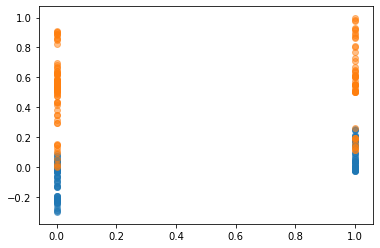

In [945]:
cor_orig = np.corrcoef(random_noise, dt_field)
cor_shifted = np.corrcoef(random_noise, newgrid)

fig, ax = plt.subplots()
field = ax.scatter(data, newgrid, alpha=.5)
field = ax.scatter(data, dt_field, alpha=.5)

In [892]:
nc_test2 = NC('synthetic_test_in.nc', 'r+')
new_bed = copy(topg_adjust)
new_bed[mask2==1] = topg_adjust[mask2==1]-newgrid[mask2==1]
new_bed[np.isnan(new_bed)] = S_ref2[np.isnan(new_bed)]
nc_test2['topg'][0,:,:]= new_bed
nc_test2['thk'][0,:,:]= np.maximum(0,S_ref2-new_bed)
nc_test2.close()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].pcolor(data-dt_fields[0], vmin=-1, vmax=1, cmap='RdBu')
ax[1].pcolor(data-newgrid, vmin=-1, vmax=1, cmap='RdBu')
ax[0].set_title('random noise - original dhdt')
ax[1].set_title('random noise - shifted dhdt')

Text(0.5, 1.0, 'difference between neighboring dhdt values, measured after x years')

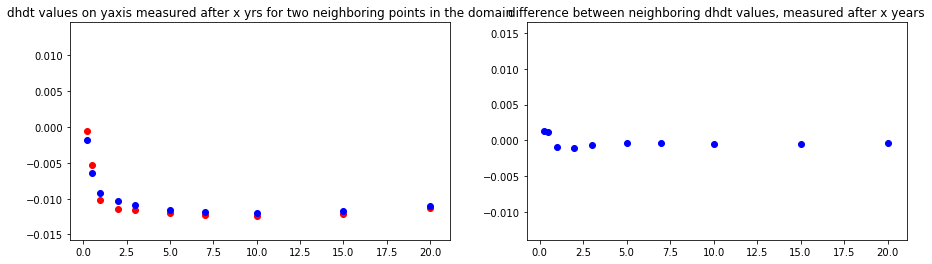

In [532]:
r, c = 30,60
r1, c1 = 31,60
fig, ax = plt.subplots(1,2, figsize=(15,4))
for i in range(len(dts)):
    ax[0].scatter(dts[i],dt_fields[i][r,c], color='r')
    ax[0].scatter(dts[i],dt_fields[i][r1,c1], color='b')
    #ax[0].set_ylim((0,0.005))
    ax[1].scatter(dts[i],dt_fields[i][r,c]-dt_fields[i][r1,c1], color='b')
    
ax[0].set_title('dhdt values on yaxis measured after x yrs for two neighboring points in the domain')
ax[1].set_title('difference between neighboring dhdt values, measured after x years')

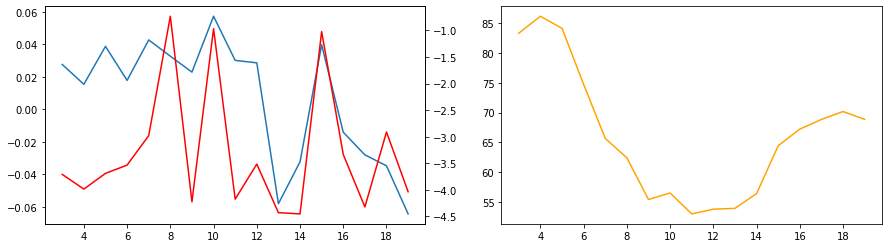

In [540]:
random_noise = topg_def-topg_adjust
random_noise[mask==0] = np.nan
dt_field = dt_fields[0]
dt_field[mask==0] = np.nan
h_out = h_outs_dot1[0]
h_out[mask==0] = np.nan
#dhdt_corr = dt_field*h_out
#dhdt_corr = (dhdt_corr-np.nanmin(dhdt_corr))/(np.nanmax((dhdt_corr))-np.nanmin(dhdt_corr))
#dhdt_corr = (dhdt_corr-1)
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].plot(range(3,20), ((dt_field[4:21,78])))#+1)**1e-1, color='b')
ax1=ax[0].twinx()
ax1.plot(range(3,20), random_noise[3:20,78], color= 'r')
#ax1.plot(range(nx), (ndimage.convolve(random_noise, np.ones((3,3)))/9)[20,:], color='orange')
ax[1].plot(range(3,20), h_out[3:20,78], color= 'orange')

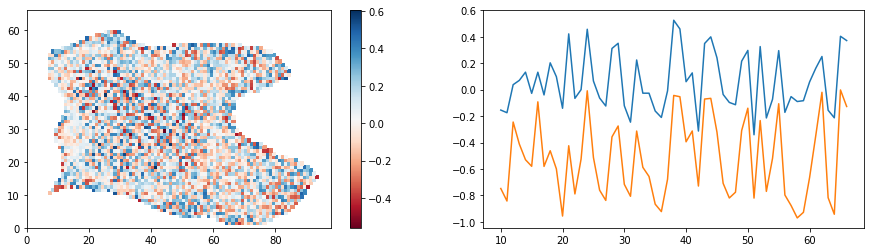

In [491]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(random_noise-dhdt_corr, cmap='RdBu')#, vmin=-1, vmax=0)
fig.colorbar(field, ax=ax[0])
line = ax[1].plot(range(nx), random_noise[30,:]-dhdt_corr[30,:])
line = ax[1].plot(range(nx), random_noise[30,:])

In [112]:
### bed recovery ###
mask2 = get_nc_data('synthetic_build_out.nc', 'mask', 0)/2
S_ref2 = get_nc_data('synthetic_build_out.nc', 'usurf', 0)
B_rec2 = np.maximum(S_ref2-300, copy(S_ref2)-H*mask2)
B_rec2[0,:] = S_ref2[0,:]
B_init2 = copy(B_rec2)
dh_ref2 = np.zeros_like(S_ref2)

slope = rd.TerrainAttribute(rd.rdarray(S_ref2, no_data=-9999), attrib='slope_riserun')
slope[mask2==0] = np.nan
slope /= res
slope = np.maximum(0.025, slope)
slope = scale(slope)


B_rec_all2 = []
dh_all2 = []
B_misfit_vs_iter2=[]
dh_misfit_vs_iter2=[]
set_max_dif2 = [100,100]

pmax = 100
dt = 0.25
beta = .5
bw = 6

!cp synthetic_build_out.nc synthetic_iteration_out2.nc
    
original_stdout = sys.stdout
with open('synthetic_iteration_script2.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x synthetic_iteration_script2.sh

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [113]:
for p in tqdm.trange(0, pmax):
    
    h_old = S_ref2 - B_rec2
    
    !cp synthetic_iteration_out2.nc synthetic_iteration_in2.nc
    nc_updated = NC('synthetic_iteration_in2.nc', 'r+')
    nc_updated['topg'][0,:,:]=B_rec2
    nc_updated['thk'][0,:,:]=h_old
    dif = nc_updated['diffusivity'][0,:,:]
    nc_updated.close()
    
    if p>1:
        set_max_dif2.append(np.nanmean(dif[dif>0]))
    
    cmd = ["./synthetic_iteration_script2.sh", '6', 'synthetic_iteration_in2.nc', str(dt+.1), 'synthetic_iteration_out2.nc', str(dt)]
    subprocess.call(cmd, stdout=open('synthetic_iteration_log2.txt', 'a'))
    
    h_rec = get_nc_data('s_synthetic_iteration_out2.nc', 'thk', -1)
    h_rec2 = get_nc_data('synthetic_iteration_out2.nc', 'thk', 0)
    
    dh_rec = (h_rec2 - h_rec)/.1
    misfit = (dh_rec - dh_ref2)
    u = get_nc_data('synthetic_iteration_out2.nc', 'uvelsurf', 0)
    v = get_nc_data('synthetic_iteration_out2.nc', 'vvelsurf', 0)
    misfit = shift(misfit, u, v)
    
    B_rec2 = B_rec2 - beta * misfit
    
    ### buffer ###
    mask_iter = get_nc_data('synthetic_iteration_out2.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
    #buffer[0:bw,:] = 0
    #buffer[:,0:bw] = 0
    #buffer[ny-bw:ny,:] = 0
    #buffer[:,nx-bw:nx] = 0
    B_rec2[np.logical_and(buffer >= .5, buffer != 1)] = np.nan #...and take those values in the transition between ice and no ice;
    B_rec2 = inpaint_nans(B_rec2)
    ### buffer end ###
    
    #B_rec2 = spline_filter(B_rec2, lmbda=.1)
    
    #if p%100==0:
    #    B_rec2 = spline_filter(B_rec2, lmbda=1)
    
    B_rec2[B_rec2>S_ref2]=S_ref2[B_rec2>S_ref2]
    B_rec2[mask2 == 0]= S_ref2[mask2 == 0]
    B_rec2[0,:] = S_ref2[0,:]
    B_rec_all2.append(B_rec2)
    dh_all2.append(dh_rec)
    
    B_misfit_vs_iter2.append(np.mean(abs(B_rec2-B_init2)))
    dh_misfit_vs_iter2.append(np.mean(abs(dh_rec-dh_ref2)))

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-111-24a27ae15dd2>:9: RuntimeWarning: invalid value encountered in sqrt
  uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
  1%|          | 1/100 [00:01<02:02,  1.23s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  2%|▏         | 2/100 [00:02<01:59,  1.22s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  3%|▎         | 3/100 [00:03<01:58,  1.22s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  4%|▍         | 4/100 [00:04<01:56,  1.21s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  5%|▌         | 5/100 [00:06<01:54,  1.21s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  6%|▌         | 6/100 [00:07<01:54,  1.21s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  7%|▋         | 7/100 [00:08<01:56,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  8%|▊         | 8/100 [00:09<01:53,  1.24s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


  9%|▉         | 9/100 [00:11<01:54,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 10%|█         | 10/100 [00:12<01:52,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 11%|█         | 11/100 [00:13<01:51,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 12%|█▏        | 12/100 [00:14<01:49,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 13%|█▎        | 13/100 [00:16<01:47,  1.24s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 14%|█▍        | 14/100 [00:17<01:45,  1.23s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 15%|█▌        | 15/100 [00:18<01:44,  1.23s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 16%|█▌        | 16/100 [00:19<01:44,  1.24s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 17%|█▋        | 17/100 [00:21<01:51,  1.34s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 18%|█▊        | 18/100 [00:22<01:48,  1.32s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 19%|█▉        | 19/100 [00:23<01:45,  1.30s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 20%|██        | 20/100 [00:25<01:43,  1.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 21%|██        | 21/100 [00:26<01:40,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 22%|██▏       | 22/100 [00:27<01:40,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 23%|██▎       | 23/100 [00:28<01:38,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 24%|██▍       | 24/100 [00:30<01:35,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 25%|██▌       | 25/100 [00:31<01:34,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 26%|██▌       | 26/100 [00:32<01:32,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 27%|██▋       | 27/100 [00:33<01:31,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 28%|██▊       | 28/100 [00:35<01:29,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 29%|██▉       | 29/100 [00:36<01:29,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 30%|███       | 30/100 [00:37<01:28,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 31%|███       | 31/100 [00:38<01:26,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 32%|███▏      | 32/100 [00:40<01:25,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 33%|███▎      | 33/100 [00:41<01:24,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 34%|███▍      | 34/100 [00:42<01:22,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 35%|███▌      | 35/100 [00:43<01:21,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 36%|███▌      | 36/100 [00:45<01:21,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 37%|███▋      | 37/100 [00:46<01:19,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 38%|███▊      | 38/100 [00:47<01:18,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 39%|███▉      | 39/100 [00:49<01:17,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 40%|████      | 40/100 [00:50<01:16,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 41%|████      | 41/100 [00:51<01:13,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 42%|████▏     | 42/100 [00:52<01:12,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 43%|████▎     | 43/100 [00:54<01:11,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 44%|████▍     | 44/100 [00:55<01:10,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 45%|████▌     | 45/100 [00:56<01:09,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 46%|████▌     | 46/100 [00:57<01:08,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 47%|████▋     | 47/100 [00:59<01:06,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 48%|████▊     | 48/100 [01:00<01:05,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 49%|████▉     | 49/100 [01:01<01:04,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 50%|█████     | 50/100 [01:02<01:03,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 51%|█████     | 51/100 [01:04<01:02,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 52%|█████▏    | 52/100 [01:05<01:01,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 53%|█████▎    | 53/100 [01:06<01:00,  1.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 54%|█████▍    | 54/100 [01:08<00:58,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 55%|█████▌    | 55/100 [01:09<00:57,  1.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 56%|█████▌    | 56/100 [01:10<00:56,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 57%|█████▋    | 57/100 [01:11<00:54,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 58%|█████▊    | 58/100 [01:13<00:53,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 59%|█████▉    | 59/100 [01:14<00:52,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 60%|██████    | 60/100 [01:15<00:51,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 61%|██████    | 61/100 [01:16<00:49,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 62%|██████▏   | 62/100 [01:18<00:48,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 63%|██████▎   | 63/100 [01:19<00:47,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 64%|██████▍   | 64/100 [01:20<00:45,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 65%|██████▌   | 65/100 [01:22<00:44,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 66%|██████▌   | 66/100 [01:23<00:42,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 67%|██████▋   | 67/100 [01:24<00:41,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 68%|██████▊   | 68/100 [01:25<00:40,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 69%|██████▉   | 69/100 [01:27<00:39,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 70%|███████   | 70/100 [01:28<00:38,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 71%|███████   | 71/100 [01:29<00:37,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 72%|███████▏  | 72/100 [01:30<00:36,  1.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 73%|███████▎  | 73/100 [01:32<00:34,  1.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 74%|███████▍  | 74/100 [01:33<00:33,  1.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 75%|███████▌  | 75/100 [01:34<00:31,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 76%|███████▌  | 76/100 [01:35<00:30,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 77%|███████▋  | 77/100 [01:37<00:29,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 78%|███████▊  | 78/100 [01:38<00:27,  1.25s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 79%|███████▉  | 79/100 [01:39<00:26,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 80%|████████  | 80/100 [01:41<00:25,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 81%|████████  | 81/100 [01:42<00:24,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 82%|████████▏ | 82/100 [01:43<00:22,  1.26s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 83%|████████▎ | 83/100 [01:44<00:21,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 84%|████████▍ | 84/100 [01:46<00:20,  1.27s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 85%|████████▌ | 85/100 [01:52<00:40,  2.72s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 86%|████████▌ | 86/100 [01:53<00:31,  2.28s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 87%|████████▋ | 87/100 [01:54<00:25,  1.97s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 88%|████████▊ | 88/100 [01:56<00:21,  1.76s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 89%|████████▉ | 89/100 [01:57<00:17,  1.62s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 90%|█████████ | 90/100 [01:58<00:15,  1.53s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 91%|█████████ | 91/100 [01:59<00:12,  1.44s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 92%|█████████▏| 92/100 [02:01<00:11,  1.38s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 93%|█████████▎| 93/100 [02:02<00:09,  1.36s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 94%|█████████▍| 94/100 [02:03<00:08,  1.34s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 95%|█████████▌| 95/100 [02:04<00:06,  1.33s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 96%|█████████▌| 96/100 [02:06<00:05,  1.31s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 97%|█████████▋| 97/100 [02:07<00:03,  1.31s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 98%|█████████▊| 98/100 [02:08<00:02,  1.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


 99%|█████████▉| 99/100 [02:10<00:01,  1.29s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


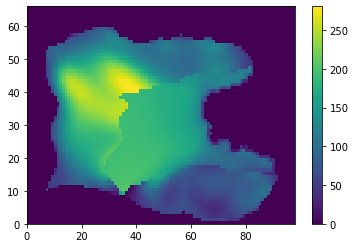

In [442]:
acc_crit = np.logical_and(mask2==1, M_ref >=0)
abl_crit = np.logical_and(mask2==1, M_ref <0)
m_acc = np.sum(S_ref2[acc_crit]-B_rec2[acc_crit])
M_abl = np.sum(M_ref[abl_crit])
slope_abl = copy(sin_slope)
slope_abl[abl_crit] = -scale(sin_slope[abl_crit])+1
tau_acc = (np.mean(sin_slope[acc_crit])*9.81*ice_density)*(m_acc)
H_rec_test = S_ref2 - B_rec2
H_rec_test[abl_crit] = ((M_abl*100+m_acc)*(slope_abl[abl_crit]/np.sum(slope_abl[abl_crit])))

fig, ax = plt.subplots()
field = ax.pcolor(H_rec_test)
fig.colorbar(field)

Text(0.5, 1.0, 'Cross section through glacier with recovered bed')

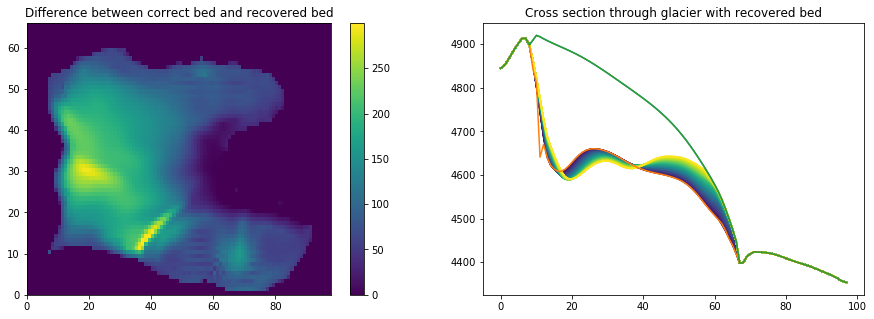

In [114]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all2))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(S_ref2-B_rec2)
fig.colorbar(field, ax=axes[0])
axes[0].set_title('Difference between correct bed and recovered bed')
for i in range(0,len(B_rec_all2),1):
    lines = axes[1].plot(range(nx), B_rec_all2[i][30,:], color=colors[i])
lines2 = axes[1].plot(range(nx), S_ref2[30,:])
lines2 = axes[1].plot(range(nx), B_init2[30,:])
usurf = get_nc_data('synthetic_iteration_out2.nc', 'usurf',0)
line3 = axes[1].plot(range(nx), usurf[30,:])
axes[1].set_title('Cross section through glacier with recovered bed')

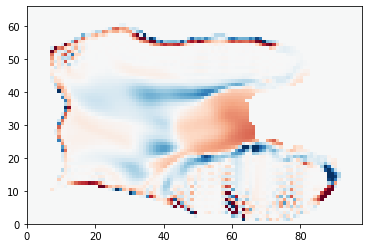

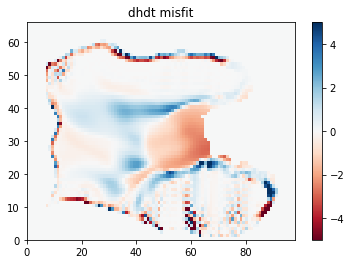

In [1023]:
fig, axes = plt.subplots()
for i in range(0,len(B_rec_all2),10):
    field = axes.pcolor((dh_all2[i]-dh_ref2), cmap='RdBu', vmin=-5, vmax=5)
    #field = axes.pcolor(S_ref2-B_rec_all2[i])
    clear_output(wait=True)
    display(fig)
axes.set_title('dhdt misfit')
fig.colorbar(field)

<ipython-input-110-948905513c47>:10: RuntimeWarning: invalid value encountered in sqrt
  uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)


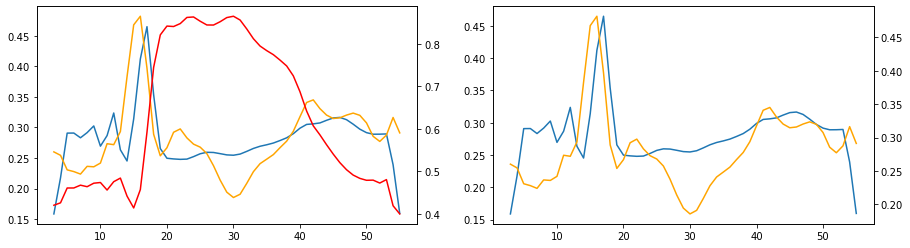

In [110]:
data = misfit
data[mask2==0] = np.nan
data = scale(data)

data2 = B_rec_all2[-1]-B_recs
data2[mask2==0] = np.nan
data2 = scale(data2)

uv_mag = np.ones_like(u)
uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
dt_field = S_ref2-B_rec2
dt_field[mask2==0] = np.nan
dt_field = scale(dt_field)

fig, ax = plt.subplots(1,2, figsize=(15,4))
field2 = ax[0].plot(range(ny), data[:,50])
field = ax[0].plot(range(ny), dt_field[:,50], color='orange')
ax1 = ax[0].twinx()
field2 = ax1.plot(range(ny), data2[:,50], color='r')


line = ax[1].plot(range(ny), data[:,50])
ax2 = ax[1].twinx()
line1 = ax2.plot(range(ny), dt_field[:,50], color='orange')

/home/thomas/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/thomas/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0, 0.5, 'recovered thickness')

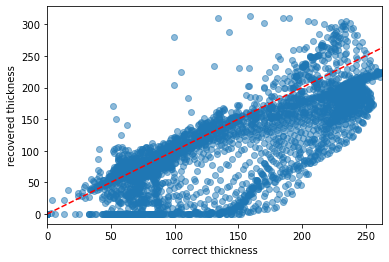

In [24]:
B_recs = get_nc_data('synthetic_build_out.nc', 'topg', 0)
cors = []
thk_rec_all = []
B_misfit = []
for i in range(0,len(B_rec_all2),1):
    thk_rec = S_ref2 - B_rec_all2[i]
    B_misfit.append(np.mean(abs(B_rec_all2[i] - B_recs)))
    thk_rec_all.append(thk_rec)
    cors.append(np.corrcoef((S_ref2-B_recs)[0], thk_rec[0])[0][1])

fig, ax = plt.subplots()
field = ax.scatter(S_ref2-B_recs, S_ref2-B_rec_all2[-1], alpha=.5)
#field = ax.scatter(S_ref2-B_recs, S_ref2-B_rec_all2[3000], color='g', alpha=.5)
ax.plot(range(300), range(300), 'r', linestyle='--')
#ax.set_box_aspect(1)
ax.set_xlim([0,np.max(thick)])
#ax.set_ylim([0,np.max(thick)])
ax.set_xlabel('correct thickness')
ax.set_ylabel('recovered thickness')

In [1008]:
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
#print(cors[max_cor_ind])
print(np.mean(((thk_rec_all[-1]-(S_ref2-B_recs))/np.mean((S_ref2-B_recs)))))

0.05266669878818401


Text(0.5, 1.0, 'correlation between correct and recovered bed per iteration')

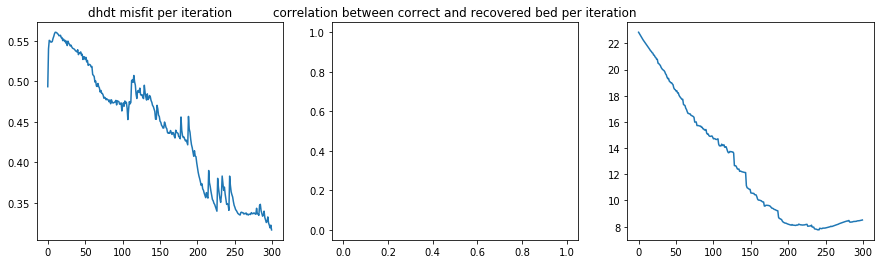

In [1009]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
line = ax[0].plot(dh_misfit_vs_iter2)
line2 = ax[1].plot(cors)
line3 = ax[2].plot(B_misfit)
ax[0].set_title('dhdt misfit per iteration')
ax[1].set_title('correlation between correct and recovered bed per iteration')

0.9749304320633543
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
0.7671828298868586


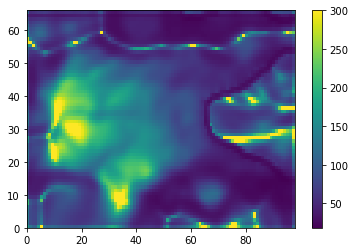

In [17]:
import richdem as rd
import math

kernel = np.ones((3, 3))
S_ref_s = copy(S_ref)
S_ref_s[mask==0] = np.nan
S_ref_s = ndimage.convolve(S_ref_s, kernel)/(3)**2

dH = (np.nanmax(S_ref[mask==1])-np.nanmin(S_ref[mask==1]))/1000 #in km

tau = 0.005+1.598*dH-0.435*dH**2  #Haeberli and Hoelzle
print(tau)

slope = rd.TerrainAttribute(rd.rdarray(S_ref, no_data=-9999), attrib='slope_riserun')
tan_slope = np.arctan(slope/res)
sin_slope = np.sin(tan_slope)
H=(tau)*1e5/(sin_slope*9.81*ice_density)
H[np.isnan(H)]=0
fig, ax = plt.subplots()
field = ax.pcolor(H, vmax = 300)
fig.colorbar(field)
print(dH)

<ipython-input-19-6016ad15a5cb>:17: RuntimeWarning: divide by zero encountered in true_divide
  ts = ((2*0.12)/(D*mask*(1/100**2+1/100**2)))/secpera


0.0024838695457440672
0.7820877526761407
-0.28691461362279563


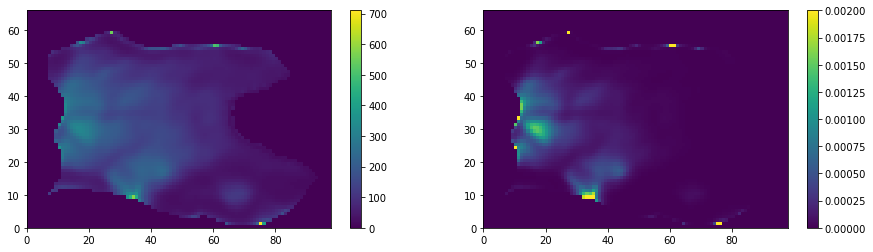

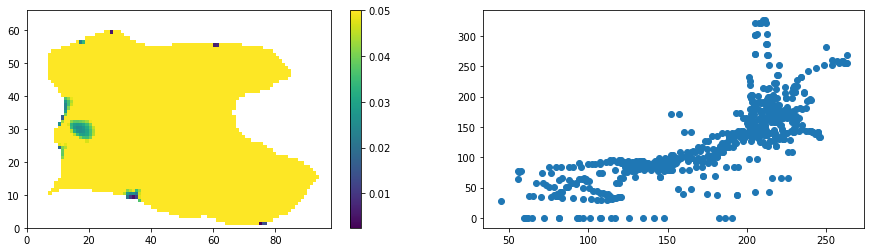

In [19]:
#compute diffusivity
T=(2*A*(9.8*ice_density)**3)/5
D=mask*T*H**5*(slope/100)**2
#H[D>3e-2] = np.nan
#H_fill = inpaint_nans(H)
H_fill = copy(H)
H_fill[H_fill>800] = np.median(H_fill)
H_fill*=mask
D=T*H_fill**5*(slope/100)**2
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(H_fill)#, vmax = 1.5e-3)
field2 = ax[1].pcolor(D, vmax = 2e-3)
fig.colorbar(field, ax=ax[0])
fig.colorbar(field2, ax=ax[1])

##time step
ts = ((2*0.12)/(D*mask*(1/100**2+1/100**2)))/secpera
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(ts, vmax=.05)
fig.colorbar(field, ax=ax[0])
field2 = ax[1].scatter(thick, H_fill[y_new, x_new])
print(np.nanmin(ts))
print(np.corrcoef(thick, H_fill[y_new,x_new])[0][1])
print(np.mean(((H_fill[y_new,x_new]-thick)/np.mean(thick))))

In [62]:
import shelve
bk = shelve.open('../it5k_bw6_beta0.5_dt2_ssa+sia_homegrown_startfromH_nodiflim.pkl','n')
for k in dir():
    try:
        bk[k] = globals()[k]
    except Exception:
        print('{} was not saved'.format(k))
        pass
bk.close()
# to restore
#bk_restore = shelve.open('./your_bk_shelve.pkl')
#for k in bk_restore:
#    globals()[k] = bk_restore[k]
#bk_restore.close()

__builtin__ was not saved
__builtins__ was not saved
bk was not saved
dill was not saved
exit was not saved
f was not saved
get_ipython was not saved
math was not saved
nc was not saved
nc_updated was not saved
ndimage was not saved
np was not saved
original_stdout was not saved
plt was not saved
quit was not saved
rd was not saved
shapefile was not saved
shelve was not saved
spatial was not saved
subprocess was not saved
sys was not saved
tqdm was not saved
var was not saved
